In [1]:
import numpy as np
import time

In [15]:

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
from neuronunit.optimization import model_parameters as modelp

from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import neuronunit.optimization as opt
import quantities as pq





# From OSB models
mparams = {}
mparams['a'] = 0.03
mparams['b'] = -2
mparams['C'] = 100
mparams['c'] = -50 
mparams['vr'] = -60
mparams['vt'] = -40
mparams['vpeak'] = 35
mparams['k'] = 0.7
mparams['d'] = 100

'''
# FROM the MOD file.
vanilla_NRN = {}
#vanilla_NRN['v0'] = -60# (mV)
vanilla_NRN['k'] = 7.0E-4# (uS / mV)
vanilla_NRN['vr'] = -60# (mV)
vanilla_NRN['vt'] = -40# (mV)
vanilla_NRN['vpeak'] = 35# (mV)
vanilla_NRN['a'] = 0.03# (kHz)
vanilla_NRN['b'] = -0.002# (uS)
vanilla_NRN['c'] = -50# (mV)
vanilla_NRN['d'] = 0.1# (nA)
vanilla_NRN['C'] = 1.0E-4# (microfarads)

m2m = {}
for k,v in vanilla_NRN.items():
    m2m[k] = vanilla_NRN[k]/mparams[k]

print(m2m)
mparams['vPeak'] = 35

'''

{'k': 0.001, 'vr': 1.0, 'vpeak': 1.0, 'd': 0.001, 'b': 0.001, 'a': 1.0, 'C': 1e-06, 'vt': 1.0, 'c': 1.0}


# compile and discard a model, to initialize the JIT
and discard, this is to purge a space and make model speed comparison fair.


In [3]:
model = None
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(mparams)
iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] = 10*pq.pA
#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 0# 100.0*pq.ms
DURATION = 520*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)

model.inject_square_current(iparams)
model = None

# Vanilla parameters model to model check (succeeds).
# RAW is significantly faster

2
3
5
7
mean simulation time: 0.0014051198959350586. Total time: 0.005620479583740234


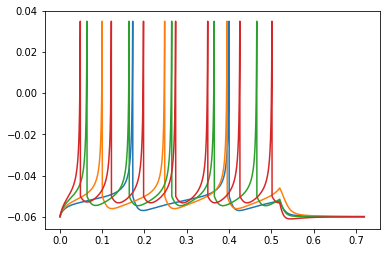

In [4]:
times = []

for current in [60,70,85,100]:
    # compile a model and discard

    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(mparams)
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0# 100.0*pq.ms
    DURATION = 520*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.results['vm'].times,model.results['vm'])
    
    times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))



In [5]:
dt = model.results['vm'].times[1] - model.results['vm'].times[0]
print(dt)

2.5e-05 s


Sim time of 0.001 s took 0.0025
Sim time of 0.0022 s took 0.0061
Sim time of 0.0046 s took 0.009
Sim time of 0.01 s took 0.019
Sim time of 0.022 s took 0.045
Sim time of 0.046 s took 0.085
Sim time of 0.1 s took 0.19
Sim time of 0.22 s took 0.4
Sim time of 0.46 s took 0.49
Sim time of 1 s took 1


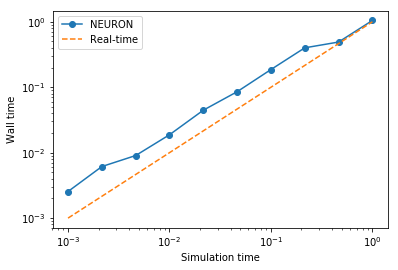

In [6]:
import time
sim_times = np.logspace(-3,0,10)*pq.s
wall_times = np.zeros(len(sim_times))
for i,sim_time in enumerate(sim_times):
    model = ReducedModel(LEMS_MODEL_PATH,name=str('vanilla'),backend='NEURON')
    model.inject_square_current({'amplitude':200*pq.pA, 'duration':sim_time/2, 'delay':100*pq.ms})
    model._backend.set_stop_time(sim_time)
    model._backend.set_time_step(0.025*pq.ms)
    start = time.time()
    result = model._backend.local_run()
    finish = time.time()
    wall_times[i] = finish - start
    print("Sim time of %.2g s took %.2g" % (sim_time,wall_times[i]))
plt.plot(sim_times,wall_times,'-o',label='NEURON')
plt.plot(sim_times,sim_times,'--',label='Real-time')
plt.xlabel('Simulation time')
plt.ylabel('Wall time')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.plot();

Sim time of 0.001 s took 0.014
Sim time of 0.0022 s took 0.001
Sim time of 0.0046 s took 0.0012
Sim time of 0.01 s took 0.001
Sim time of 0.022 s took 0.00092
Sim time of 0.046 s took 0.00092
Sim time of 0.1 s took 0.0011
Sim time of 0.22 s took 0.001
Sim time of 0.46 s took 0.00093
Sim time of 1 s took 0.00093


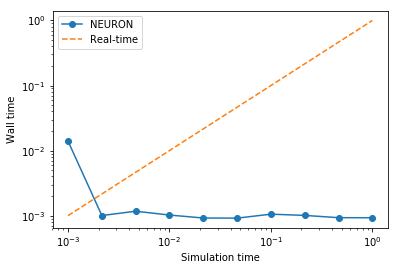

In [7]:
import time
sim_times = np.logspace(-3,0,10)*pq.s
wall_times = np.zeros(len(sim_times))
for i,sim_time in enumerate(sim_times):
    model = ReducedModel(LEMS_MODEL_PATH,name=str('vanilla'),backend='RAW')
    model.set_attrs(mparams)
    model.inject_square_current({'amplitude':200*pq.pA, 'duration':sim_time/2, 'delay':100*pq.ms})
    model._backend.set_stop_time(sim_time)
    #model._backend.set_time_step(0.025*pq.ms)
    start = time.time()
    result = model._backend.local_run()
    finish = time.time()
    wall_times[i] = finish - start
    print("Sim time of %.2g s took %.2g" % (sim_time,wall_times[i]))
plt.plot(sim_times,wall_times,'-o',label='NEURON')
plt.plot(sim_times,sim_times,'--',label='Real-time')
plt.xlabel('Simulation time')
plt.ylabel('Wall time')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.plot();

2
0.3918569087982178 simulation
3
0.38318800926208496 simulation
5
0.39646315574645996 simulation
7
0.37295007705688477 simulation
mean simulation time: 0.38611453771591187. Total time: 1.5444581508636475
0.3869502544403076 finish
0.3789191246032715 finish
0.3838818073272705 finish
0.38811588287353516 finish
without init NEURON simulation time: 0.3844667673110962. Total time: 1.5378670692443848


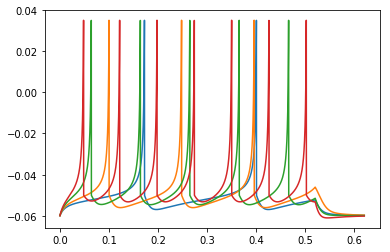

In [25]:

import time
times = []
times_without_init = []

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))


#model.set_attrs(mparams)
for current in [60,70,85,100]:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    DELAY = 0# 100.0*pq.ms
    DURATION = 520
    iparams['injected_square_current']['delay'] = DELAY*pq.ms
    iparams['injected_square_current']['duration'] = DURATION*pq.ms

    model.inject_square_current(iparams)
    
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    print(model.results['sim_time'], 'simulation')
    times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))


for current in [60,70,85,100]:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    DELAY = 0# 100.0*pq.ms
    DURATION = 520
    iparams['injected_square_current']['delay'] = DELAY*pq.ms
    iparams['injected_square_current']['duration'] = DURATION*pq.ms
    model.inject_square_current(iparams)

    #model.inject_square_current(iparams)
    #model.inject_square_current(iparams)

    start = time.time()
    model._backend.h('run()')
    stop = time.time()
    finish = stop-start
    print(finish,'finish')
    times_without_init.append(finish)
print('without init NEURON simulation time: {0}. Total time: {1}'.format(np.mean(times_without_init),np.sum(times_without_init)))


In [9]:

#model._backend.h('psection()')


NEURON units                                           NeuroML units   

v0 = -60 (mV),  vr = -60 (mV) ,                        mparams['vr'] = -60

k = 7.0E-4 (uS / mV),                                  mparams['k'] = 0.7                ***different

vt = -40 (mV)

vpeak = 35 (mV)                 mparams['vPeak'] = 35

a = 0.030000001 (kHz) [ms-1],   mparams['a'] = 0.03

b = -0.002 (uS),                mparams['b'] = -2

c = -50 (mV),                   mparams['c'] = -50  

d = 0.1 (nA) --MATLAB pA        mparams['d'] = 100  ******** pA

C = 1.0E-4 (microfarads)        mparams['C'] = 100 ******** co faraday)

In [29]:
import collections
# Fast spiking cannot be reproduced as it requires modifications to the standard Izhi equation,
# which are expressed in this mod file.
# https://github.com/OpenSourceBrain/IzhikevichModel/blob/master/NEURON/izhi2007b.mod

from collections import OrderedDict
type2007 = collections.OrderedDict([
  #              C    k     vr  vt vpeak   a      b   c    d  celltype
  ('RS',        (100, 0.7,  -60, -40, 35, 0.03,   -2, -50,  100,  1)),
  ('IB',        (150, 1.2,  -75, -45, 50, 0.01,   5, -56,  130,   2)),
  ('CH',        (50,  1.5,  -60, -40, 25, 0.03,   1, -40,  150,   3)),
  ('LTS',       (100, 1.0,  -56, -42, 40, 0.03,   8, -53,   20,   4)),
  ('FS',        (20,  1.0,  -55, -40, 25, 0.2,   -2, -45,  -55,   5)),
  ('TC',        (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('TC_burst',  (200, 1.6,  -60, -50, 35, 0.01,  15, -60,   10,   6)),
  ('RTN',       (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7)),
  ('RTN_burst', (40,  0.25, -65, -45,  0, 0.015, 10, -55,   50,   7))])

import numpy as np
param_dict = OrderedDict([(k,[]) for k in ['C','k','vr','vt','vPeak','a','b','c','d']])
#OrderedDict
for i,k in enumerate(param_dict.keys()):
    for v in type2007.values():
        param_dict[k].append(v[i])

explore_param = {k:(np.min(v),np.max(v)) for k,v in param_dict.items()}
param_ranges = OrderedDict(explore_param)


#IB = mparams[param_dict['IB']]
IB = {}
TC = {}
CH = {}
RTN_burst = {}
for k,v in param_dict.items():
    IB[k] = v[1]
    CH[k] = v[2]
    TC[k] = v[5]
    RTN_burst[k] = v[-2]
    
RTN_burstN = copy.copy(RTN_burst)
TCN = copy.copy(TC)
IBN = copy.copy(IB)
CHN = copy.copy(CH)


# From OSB models
mparams = {}
mparams['a'] = 0.03
mparams['b'] = -2
mparams['C'] = 100
mparams['c'] = -50 
mparams['vr'] = -60
mparams['vt'] = -40
mparams['vpeak'] = 35
mparams['k'] = 0.7
mparams['d'] = 100


# FROM the MOD file.
vanilla_NRN = {}
#vanilla_NRN['v0'] = -60# (mV)
vanilla_NRN['k'] = 7.0E-4# (uS / mV)
vanilla_NRN['vr'] = -60# (mV)
vanilla_NRN['vt'] = -40# (mV)
vanilla_NRN['vpeak'] = 35# (mV)
vanilla_NRN['a'] = 0.03# (kHz)
vanilla_NRN['b'] = -0.002# (uS)
vanilla_NRN['c'] = -50# (mV)
vanilla_NRN['d'] = 0.1# (nA)
vanilla_NRN['C'] = 1.0E-4# (microfarads)

m2m = {}
for k,v in vanilla_NRN.items():
    m2m[k] = vanilla_NRN[k]/mparams[k]


def translate(input_dic,m2m):
    input_dic['vpeak'] = input_dic['vPeak']
    input_dic.pop('vPeak', None)     
    input_dic.pop('dt', None)        
    for k,v in input_dic.items():
        input_dic[k] = v * m2m[k]
    return input_dic
IBN = translate(IBN,m2m)
CHN = translate(CHN,m2m)
TCN = translate(TCN,m2m)
print(CH)
print(CHN)
print(IB)
print(IBN)
print(TC)
print(TCN)

{'vPeak': 25, 'C': 50, 'vr': -60, 'b': 1, 'c': -40, 'd': 150, 'a': 0.03, 'k': 1.5, 'vt': -40}
{'C': 4.9999999999999996e-05, 'c': -40.0, 'vpeak': 25.0, 'd': 0.15, 'a': 0.03, 'vt': -40.0, 'k': 0.0015, 'vr': -60.0, 'b': 0.001}
{'vPeak': 50, 'C': 150, 'vr': -75, 'b': 5, 'c': -56, 'd': 130, 'a': 0.01, 'k': 1.2, 'vt': -45}
{'C': 0.00015, 'c': -56.0, 'vpeak': 50.0, 'd': 0.13, 'a': 0.01, 'vt': -45.0, 'k': 0.0012, 'vr': -75.0, 'b': 0.005}
{'vPeak': 35, 'C': 200, 'vr': -60, 'b': 15, 'c': -60, 'd': 10, 'a': 0.01, 'k': 1.6, 'vt': -50}
{'C': 0.00019999999999999998, 'c': -60.0, 'vpeak': 35.0, 'd': 0.01, 'a': 0.01, 'vt': -50.0, 'k': 0.0016, 'vr': -60.0, 'b': 0.015}


The following cells follow the Backend pattern RAW, NEURON, RAW, NEURON.

0
0.0008738040924072266 simulation
1
0.0007090568542480469 simulation
3
0.0006754398345947266 simulation
5
0.0006630420684814453 simulation
mean simulation time: 0.0007303357124328613. Total time: 0.0029213428497314453


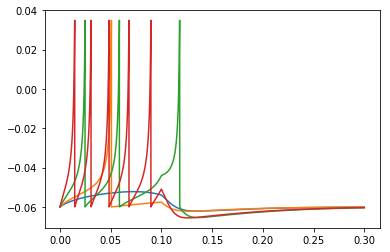

In [30]:
tstop = 100*pq.ms
IinRange = [73.2,100,200,400]

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))


model.set_attrs(TC)
#print(FS)
times = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0
    iparams['injected_square_current']['duration'] = 100*pq.ms

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    print(model.results['sim_time'], 'simulation')
    times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    


{'C': 0.00019999999999999998, 'c': -60.0, 'vpeak': 35.0, 'd': 0.01, 'a': 0.01, 'vt': -50.0, 'k': 0.0016, 'vr': -60.0, 'b': 0.015}
1
0.13012313842773438 simulation
{'C': 0.00019999999999999998, 'c': -60.0, 'vpeak': 35.0, 'd': 0.01, 'a': 0.01, 'vt': -50.0, 'k': 0.0016, 'vr': -60.0, 'b': 0.015}
2
0.12086725234985352 simulation
{'C': 0.00019999999999999998, 'c': -60.0, 'vpeak': 35.0, 'd': 0.01, 'a': 0.01, 'vt': -50.0, 'k': 0.0016, 'vr': -60.0, 'b': 0.015}
5
0.1221153736114502 simulation
{'C': 0.00019999999999999998, 'c': -60.0, 'vpeak': 35.0, 'd': 0.01, 'a': 0.01, 'vt': -50.0, 'k': 0.0016, 'vr': -60.0, 'b': 0.015}
10
0.1243281364440918 simulation
mean simulation time: 0.12435847520828247. Total time: 0.4974339008331299
{'vPeak': 35, 'C': 200, 'vr': -60, 'b': 15, 'c': -60, 'd': 10, 'a': 0.01, 'k': 1.6, 'vt': -50}


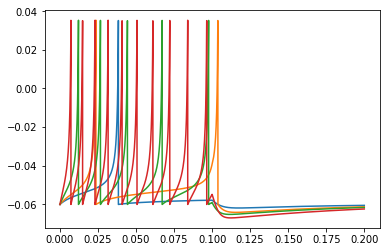

In [31]:
tstop = 100*pq.ms
IinRange = [73.2,100,200,400]


times = []
for current in IinRange:
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))

    model.set_attrs(TCN)
    print(TCN)

    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA

    iparams['injected_square_current']['delay'] = 0*pq.ms
    iparams['injected_square_current']['duration'] = 100*pq.ms

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    print(model.results['sim_time'], 'simulation')
    times.append(model.results['sim_time'])
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))   
#plt.plot(model.results['vm'].times,model.results['vm'])
    
print(TC)

In [32]:
  # CH
tstop = 210
IinRange = [200,300,400,600]

{'vPeak': 0, 'C': 40, 'vr': -65, 'b': 10, 'c': -55, 'd': 50, 'a': 0.015, 'k': 0.25, 'vt': -45}
{'vPeak': 0, 'C': 40, 'vr': -65, 'b': 10, 'c': -55, 'd': 50, 'a': 0.015, 'k': 0.25, 'vt': -45}
0
0.0013985633850097656 simulation
0
0.0013499259948730469 simulation
0
0.001348257064819336 simulation


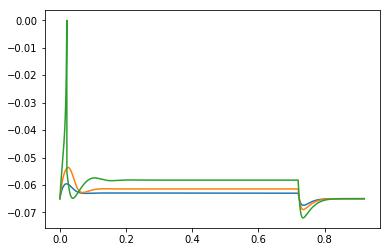

In [33]:
IinRange = [30,50,90]
tstop=720
print(RTN_burst)
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(RTN_burst)
print(RTN_burst)
times = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    #DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = 0
    iparams['injected_square_current']['duration'] = tstop*pq.ms

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    times.append(model.results['sim_time'])

    print(model.results['sim_time'], 'simulation')    

9
11
19
20
mean simulation time: 0.0008618831634521484. Total time: 0.0034475326538085938


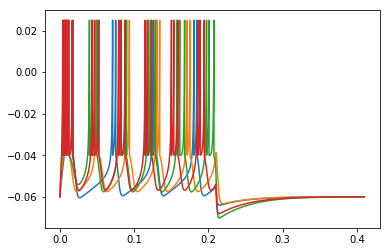

In [34]:
tstop = 210
IinRange = [290,370,500,550]
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(CH)
times = []
for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0
    DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)

    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    times.append(model.results['sim_time'])

print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    
    

7
0.1985156536102295 simulation
11
0.19085168838500977 simulation
19
0.19084787368774414 simulation
21
0.1939389705657959 simulation
mean simulation time: 0.0008618831634521484. Total time: 0.0034475326538085938


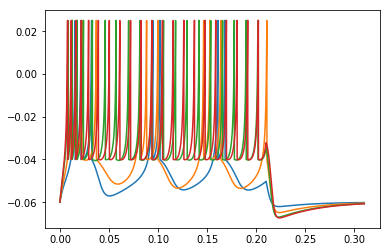

In [35]:
tstop = 210
IinRange = [290,370,500,550]

for current in IinRange:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = current*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 0*pq.ms
    DURATION = tstop*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = DURATION
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('NEURON'))
    model.set_attrs(CHN)
    model.inject_square_current(iparams)
    print(model.get_spike_count())
    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())
    print(model.results['sim_time'], 'simulation')    
print('mean simulation time: {0}. Total time: {1}'.format(np.mean(times),np.sum(times)))    
    

6


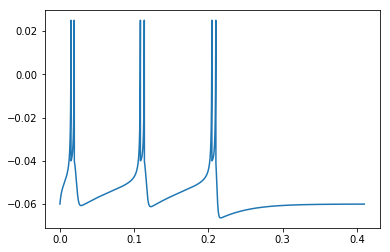

In [36]:
iparams = {}
iparams['injected_square_current'] = {}
iparams['injected_square_current']['amplitude'] = 200*pq.pA
#['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
DELAY = 0*pq.ms
DURATION = tstop*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = DURATION

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
#model.set_attrs(CHN)
model.set_attrs(CH)

model.inject_square_current(iparams)
print(model.get_spike_count())
plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())



Ignore the rest of cells


In [37]:

model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
model.set_attrs(mparams)

import seaborn as sns
from neuronunit.optimization.data_transport_container import DataTC
import os
print(dir(model._backend))#.attrs)




params = {}
params['injected_square_current'] = {}
params['injected_square_current']['amplitude'] = 52*pq.pA
DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
params['injected_square_current']['delay'] = DELAY
params['injected_square_current']['duration'] = DURATION

#first_two[0].observation['mean'] = 50*pq.pA

#first_two[1].observation['mean'] = 50*pq.ohm*1e6

#print(first_two)

score = first_two[1].judge(model,stop_on_error = False, deep_error = True)
print(score)
stuff = first_two[1].generate_prediction(model)
print(stuff)
print(model.get_spike_count(),'npsikes')
print(np.mean(model.get_membrane_potential()),'mean membrane potential')


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cell_name', '_local_run', 'attrs', 'backend', 'check_run_params', 'current_src_name', 'f', 'get_disk_cache', 'get_membrane_potential', 'get_memory_cache', 'init_backend', 'init_cache', 'init_disk_cache', 'init_memory_cache', 'inject_square_current', 'load_model', 'local_run', 'memory_cache', 'model', 'save_results', 'set_attrs', 'set_disk_cache', 'set_memory_cache', 'set_run_params', 'set_stop_time', 'sim_time', 'temp_attrs', 'use_disk_cache', 'use_memory_cache', 'vM']


NameError: name 'first_two' is not defined

In [ ]:
score = first_two[1].judge(model,stop_on_error = False, deep_error = True)
print(score.prediction)
print(model.get_spike_count())

In [ ]:
score = first_two[0].judge(model,stop_on_error = False, deep_error = True)
print(score.prediction)
#print(model.get_spike_count())

In [ ]:

model = None
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))#,{'DTC':dtc}))
model.set_attrs(mparams)

prediction = all_tests[0].generate_prediction(model)
print(prediction)

prediction1 = all_tests[1].generate_prediction(model)
print(prediction1)

In [ ]:

cnt = 0
scores = []
tests_,all_tests, observation,suite = opt.get_neab.get_tests()
#passive  = [ str('RestingPotentialTest'), str('CapacitanceTest'), str('TimeConstantTest'), str('InputResistanceTest') ]
#firing_tests =  [ t for t in all_tests if str(t) not in passive ]

print(first_two)

for t in all_tests:
    score = t.judge(model,stop_on_error = False, deep_error = True)
        
    if cnt==0:
        model.rheobase = score.prediction['value']
        
        params = {}
        params['injected_square_current'] = {}
        params['injected_square_current']['amplitude'] = score.prediction['value']
        DELAY = 100.0*pq.ms
        DURATION = 1000.0*pq.ms
        params['injected_square_current']['delay'] = DELAY
        params['injected_square_current']['duration'] = DURATION
        model.params = params
    scores.append(score)
    print(score)
    print('score {0}'.format(score))
    if str('mean') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['mean']))
    if str('value') in score.prediction.keys():
        print('observation {0}, prediction {1}'.format(t.observation['mean'],score.prediction['value']))
    cnt+=1
#http://www.physics

In [ ]:
import pandas as pd
import numpy as np
k_grid = np.logspace(-1.5,1,10)
#k_grid = np.logspace(-2,-1,10)
#k_grid = np.logspace(-1,1,10)


print(k_grid)

params = {}
params['a'] = 0.03
params['b'] = -2
params['C'] = 100
params['c'] = -50 
params['vr'] = -60
params['vt'] = -40
params['vPeak'] = 35
params['k'] = 0.7
params['d'] = 100
params['dt'] = 0.025
params['tMax'] = 1000.0;#   % max time [ms]
first_two = all_tests[0:2]
list_dics = []                                         
fig = plt.figure()
import copy
import pdb
tests_ = all_tests[0:2]
for k in k_grid:
    LEMS_MODEL_PATH = path_params['model_path']
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name=str('vanilla'),backend='NEURON')
    params['k'] = k
    model.set_attrs(params)

    scores = []
    for index,t in enumerate(first_two):
        print("k=%.2g; Test=%s" % (k,t))
        score = t.judge(model, stop_on_error=True, deep_error=False)
        print(score.prediction,'rheobase why not?')
        scores.append(score)

    for s in scores:
        agreement = {}
        agreement['k'] = k
        print('bad k', k)
        agreement['test'] = s.test
        try:
            agreement['observation'] = s.observation['mean'].rescale(s.test.units)
            agreement['prediction'] = s.prediction['value'].rescale(s.test.units)
            agreement['agreement'] = float(agreement['observation'])/float(agreement['prediction'])
        except Exception as e:
            print('error score skip because %s' % e)
            agreement['agreement'] = None
        list_dics.append(agreement)




In [ ]:
#pd.set_option('display.precision', 3)
df = pd.DataFrame(list_dics)
dfg = df.reset_index(drop=True)
#dfg = dfg.dropna()
#dfg
#how='all'
#dfg = df.reset_index(drop=nan)


import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
#display(dfg.style.background_gradient(cmap=cm,subset=['agreement']))
#df
#ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')

ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')
df[df['test'].index % 2 == 1].plot(x='k',y='agreement',label='InputRes', ax=ax)
plt.plot(k_grid,np.ones(k_grid.shape),'--')
#plt.xscale('log')
#plt.yscale('log')

plt.xscale('log')
plt.yscale('log')

In [ ]:
list_dics

In [ ]:
print(k_grid)

In [ ]:
k_grid = np.logspace(-1,0,10)


In [ ]:
print(k_grid)

In [ ]:

import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
#display(dfg.style.background_gradient(cmap=cm,subset=['agreement']))
#df

ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')
#df[df['test'].index % 2 == 1].plot(x='k',y='agreement',label='InputRes', ax=ax)
plt.plot(k_grid,np.ones(k_grid.shape),'--')
plt.xscale('log')
plt.yscale('log')

In [ ]:
ax = df[df['test'].index % 2 == 0].plot(x='k',y='agreement',label='Rheobase')


In [ ]:
# tests that do well, 4th last to second last.
# rheobase.
ft_ = all_tests[-4:-2]
ft_.insert(0,all_tests[0]) 
print(ft_)
free_params = ['k','b']
from neuronunit.optimization import optimization_management as om
ga_out, DO = om.run_ga(mp,3,ft_,free_params=free_params)


In [ ]:
type2007.keys()

In [ ]:
for k, v in type2007.items():
    print(v)

In [ ]:
param_dict